In [1]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


print(torch.__version__)

1.12.0+cu102


In [5]:
paths = np.load('./data/alanine-dipeptide-3x250ns-heavy-atom-positions.npz')

print(paths['arr_0'].shape)
print(paths['arr_1'].shape)
print(paths['arr_2'].shape)

(250000, 30)
(250000, 30)
(250000, 30)


In [6]:
###---------Transformation Functions----###
def center_com(paths):
    """Align paths to COM at each frame"""
    coms = np.mean(paths, axis=-2, keepdims=True)
    return paths - coms


def make_2drot(angle):
    mats = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    # swap so batch axis is first
    return np.swapaxes(mats, 0, -1)


def find_principle_axis(points):
    """Compute single principle axis for points"""
    inertia = points.T @ points
    evals, evecs = np.linalg.eigh(inertia)
    # get biggest eigenvalue
    order = np.argsort(evals)
    return evecs[:, order[-1]]


def align_principle(paths, axis_finder=find_principle_axis):
    # This is a degenarate version, I removed mirror disambiguation
    # to make latent space jump less. Data augmentation will
    # have to overcome this issue
    # the code is commented out below
    vecs = [axis_finder(p) for p in paths]
    vecs = np.array(vecs)
    # find angle to rotate so these are pointed towards pos x
    cur_angle = np.arctan2(vecs[:, 1], vecs[:, 0])
    # cross = np.cross(vecs[:,0], vecs[:,1])
    rot_angle = -cur_angle  # - (cross < 0) * np.pi
    rot_mat = make_2drot(rot_angle)
    return paths @ rot_mat


###-----------------------------------###

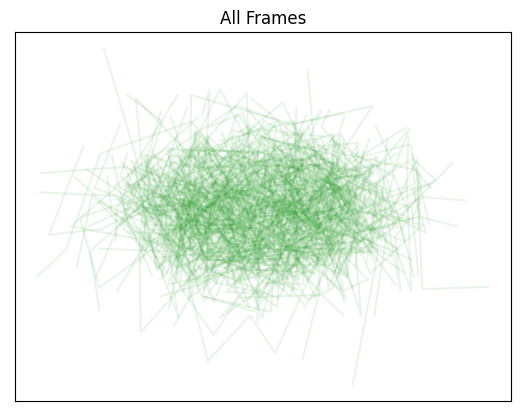

In [7]:
paths = np.load("./data/long_paths.npz")["arr"]
# transform to be rot/trans invariant
data = align_principle(center_com(paths))
cmap = plt.get_cmap("cool")
for i in range(0, data.shape[0], 16):
    plt.plot(data[i, :, 0], data[i, :, 1], "-", alpha=0.1, color="C2")
plt.title("All Frames")
plt.xticks([])
plt.yticks([])
plt.show()

In [8]:
data.shape

(2048, 12, 2)

/tmp/ipykernel_191605/3229852299.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.linalg.norm(data[:, 0] - data[:, j], axis=1), ax=axs[i])
/tmp/ipykernel_191605/3229852299.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.linalg.norm(data[:, 0] - data[:, j], axis=1), ax=axs[i])
/tmp/i

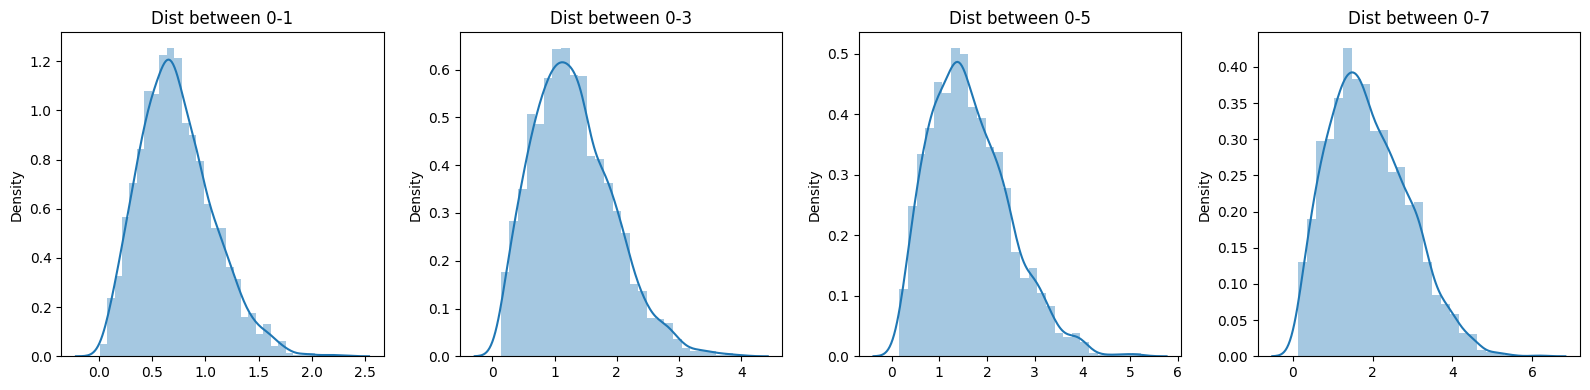

In [9]:
import seaborn as sns


fig, axs = plt.subplots(ncols=4, squeeze=True, figsize=(16, 4))
for i, j in enumerate(range(1, 9, 2)):
    axs[i].set_title(f"Dist between 0-{j}")
    sns.distplot(np.linalg.norm(data[:, 0] - data[:, j], axis=1), ax=axs[i])
plt.tight_layout()

In [19]:
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 32

x_dim = 12*2
hidden_dim = 256
latent_dim = 2

lr = 1e-3

epochs = 250

In [20]:
import torch.nn as nn


class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_input3 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True
    
    def forward(self, x):
        h_ = self.LeakyReLU(self.FC_input(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        h_ = self.LeakyReLU(self.FC_input3(h_))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.FC_hidden(x))
        h = self.LeakyReLU(self.FC_hidden2(h))
        h = self.LeakyReLU(self.FC_hidden3(h))

        x_hat = self.FC_output(h)
        return x_hat
    

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        
        z = mean + var*epsilon                          
        return z
    
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5*log_var)) 
        x_hat = self.Decoder(z)

        return x_hat, mean, log_var

In [21]:
encoder = Encoder(x_dim, hidden_dim, latent_dim).to(DEVICE)
decoder = Decoder(latent_dim, hidden_dim, x_dim).to(DEVICE)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [22]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 获取给定索引的数据点，并将其转换为PyTorch张量
        sample = torch.Tensor(self.data[idx])
        return sample


kwargs = {'num_workers': 1, 'pin_memory': True} 

dataset = CustomDataset(data)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, **kwargs)

In [23]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    # reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')  
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1+ 2*log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + 0.01*KLD, reproduction_loss, 0.01*KLD
    
optimizer = Adam(model.parameters(), lr=lr)

In [24]:
print("Start training VAE...")
model.train()

losses = []
klds = []
reproduction_losses = []

for epoch in range(epochs):
    overall_loss = 0
    overall_kld = 0
    overall_reproduction_loss = 0
    for batch_idx, x in enumerate(tqdm(train_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, x_mean, x_log_var = model(x)
        loss, repro_loss, kld = loss_function(x, x_hat, x_mean, x_log_var)

        overall_loss += loss.item()
        overall_kld += kld.item()
        overall_reproduction_loss += repro_loss.item()

        loss.backward()
        optimizer.step()
    
    losses.append(overall_loss / (batch_idx*batch_size))
    klds.append(overall_kld / (batch_idx*batch_size))
    reproduction_losses.append(overall_reproduction_loss / (batch_idx*batch_size))

    print("\tEpoch", epoch+1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...


100%|██████████| 64/64 [00:00<00:00, 106.82it/s]


	Epoch 1 complete! 	Average Loss:  8.265475091480074


100%|██████████| 64/64 [00:00<00:00, 141.41it/s]


	Epoch 2 complete! 	Average Loss:  5.745199536520337


100%|██████████| 64/64 [00:00<00:00, 121.22it/s]


	Epoch 3 complete! 	Average Loss:  4.982605192396376


100%|██████████| 64/64 [00:00<00:00, 116.31it/s]


	Epoch 4 complete! 	Average Loss:  4.939969619115193


100%|██████████| 64/64 [00:00<00:00, 120.03it/s]


	Epoch 5 complete! 	Average Loss:  4.930742975265261


100%|██████████| 64/64 [00:00<00:00, 130.66it/s]


	Epoch 6 complete! 	Average Loss:  4.914214815412249


100%|██████████| 64/64 [00:00<00:00, 131.46it/s]


	Epoch 7 complete! 	Average Loss:  4.887492300972106


100%|██████████| 64/64 [00:00<00:00, 108.52it/s]


	Epoch 8 complete! 	Average Loss:  4.896017748212057


100%|██████████| 64/64 [00:00<00:00, 136.11it/s]


	Epoch 9 complete! 	Average Loss:  4.862375346441118


100%|██████████| 64/64 [00:00<00:00, 129.87it/s]


	Epoch 10 complete! 	Average Loss:  4.851512848384797


100%|██████████| 64/64 [00:00<00:00, 119.00it/s]


	Epoch 11 complete! 	Average Loss:  4.84175201446291


100%|██████████| 64/64 [00:00<00:00, 124.02it/s]


	Epoch 12 complete! 	Average Loss:  4.8178589230492


100%|██████████| 64/64 [00:00<00:00, 108.61it/s]


	Epoch 13 complete! 	Average Loss:  4.821337234406244


100%|██████████| 64/64 [00:00<00:00, 131.91it/s]


	Epoch 14 complete! 	Average Loss:  4.782880601428804


100%|██████████| 64/64 [00:00<00:00, 112.90it/s]


	Epoch 15 complete! 	Average Loss:  4.770945238688635


100%|██████████| 64/64 [00:00<00:00, 109.04it/s]


	Epoch 16 complete! 	Average Loss:  4.771011329832531


100%|██████████| 64/64 [00:00<00:00, 108.40it/s]


	Epoch 17 complete! 	Average Loss:  4.757529092213464


100%|██████████| 64/64 [00:00<00:00, 97.33it/s] 


	Epoch 18 complete! 	Average Loss:  4.753795328594389


100%|██████████| 64/64 [00:00<00:00, 121.97it/s]


	Epoch 19 complete! 	Average Loss:  4.721562351499285


100%|██████████| 64/64 [00:00<00:00, 136.89it/s]


	Epoch 20 complete! 	Average Loss:  4.721538123630342


100%|██████████| 64/64 [00:00<00:00, 132.70it/s]


	Epoch 21 complete! 	Average Loss:  4.695438332027859


100%|██████████| 64/64 [00:00<00:00, 99.58it/s] 


	Epoch 22 complete! 	Average Loss:  4.6741038087814575


100%|██████████| 64/64 [00:00<00:00, 120.04it/s]


	Epoch 23 complete! 	Average Loss:  4.691268103463309


100%|██████████| 64/64 [00:00<00:00, 118.01it/s]


	Epoch 24 complete! 	Average Loss:  4.695879781056965


100%|██████████| 64/64 [00:00<00:00, 107.17it/s]


	Epoch 25 complete! 	Average Loss:  4.641820131786286


100%|██████████| 64/64 [00:00<00:00, 119.39it/s]


	Epoch 26 complete! 	Average Loss:  4.660258414253356


100%|██████████| 64/64 [00:00<00:00, 119.61it/s]


	Epoch 27 complete! 	Average Loss:  4.619926289906577


100%|██████████| 64/64 [00:00<00:00, 132.97it/s]


	Epoch 28 complete! 	Average Loss:  4.636717035656884


100%|██████████| 64/64 [00:00<00:00, 131.05it/s]


	Epoch 29 complete! 	Average Loss:  4.6108713036491755


100%|██████████| 64/64 [00:00<00:00, 137.37it/s]


	Epoch 30 complete! 	Average Loss:  4.590774933497111


100%|██████████| 64/64 [00:00<00:00, 156.77it/s]


	Epoch 31 complete! 	Average Loss:  4.581764024401468


100%|██████████| 64/64 [00:00<00:00, 150.96it/s]


	Epoch 32 complete! 	Average Loss:  4.545284237180438


100%|██████████| 64/64 [00:00<00:00, 138.62it/s]


	Epoch 33 complete! 	Average Loss:  4.560018849751306


100%|██████████| 64/64 [00:00<00:00, 148.64it/s]


	Epoch 34 complete! 	Average Loss:  4.563440224481007


100%|██████████| 64/64 [00:00<00:00, 141.44it/s]


	Epoch 35 complete! 	Average Loss:  4.563435134433565


100%|██████████| 64/64 [00:00<00:00, 119.07it/s]


	Epoch 36 complete! 	Average Loss:  4.541289817719233


100%|██████████| 64/64 [00:00<00:00, 111.86it/s]


	Epoch 37 complete! 	Average Loss:  4.496733983357747


100%|██████████| 64/64 [00:00<00:00, 122.48it/s]


	Epoch 38 complete! 	Average Loss:  4.519777850499229


100%|██████████| 64/64 [00:00<00:00, 130.39it/s]


	Epoch 39 complete! 	Average Loss:  4.511407681873867


100%|██████████| 64/64 [00:00<00:00, 122.54it/s]


	Epoch 40 complete! 	Average Loss:  4.482661795994592


100%|██████████| 64/64 [00:00<00:00, 117.65it/s]


	Epoch 41 complete! 	Average Loss:  4.462893024323479


100%|██████████| 64/64 [00:00<00:00, 120.60it/s]


	Epoch 42 complete! 	Average Loss:  4.48495106091575


100%|██████████| 64/64 [00:00<00:00, 117.39it/s]


	Epoch 43 complete! 	Average Loss:  4.456571499506633


100%|██████████| 64/64 [00:00<00:00, 125.28it/s]


	Epoch 44 complete! 	Average Loss:  4.468595989166745


100%|██████████| 64/64 [00:00<00:00, 109.90it/s]


	Epoch 45 complete! 	Average Loss:  4.452490462197198


100%|██████████| 64/64 [00:00<00:00, 108.32it/s]


	Epoch 46 complete! 	Average Loss:  4.440491388714503


100%|██████████| 64/64 [00:00<00:00, 121.72it/s]


	Epoch 47 complete! 	Average Loss:  4.412972124796065


100%|██████████| 64/64 [00:00<00:00, 139.25it/s]


	Epoch 48 complete! 	Average Loss:  4.432933731684609


100%|██████████| 64/64 [00:00<00:00, 143.69it/s]


	Epoch 49 complete! 	Average Loss:  4.395709139960153


100%|██████████| 64/64 [00:00<00:00, 172.85it/s]


	Epoch 50 complete! 	Average Loss:  4.394144591831026


100%|██████████| 64/64 [00:00<00:00, 134.12it/s]


	Epoch 51 complete! 	Average Loss:  4.399963405397203


100%|██████████| 64/64 [00:00<00:00, 112.70it/s]


	Epoch 52 complete! 	Average Loss:  4.379011445575291


100%|██████████| 64/64 [00:00<00:00, 128.24it/s]


	Epoch 53 complete! 	Average Loss:  4.354591464239453


100%|██████████| 64/64 [00:00<00:00, 125.15it/s]


	Epoch 54 complete! 	Average Loss:  4.354358514149983


100%|██████████| 64/64 [00:00<00:00, 108.74it/s]


	Epoch 55 complete! 	Average Loss:  4.386337518692017


100%|██████████| 64/64 [00:00<00:00, 110.93it/s]


	Epoch 56 complete! 	Average Loss:  4.364414207519046


100%|██████████| 64/64 [00:00<00:00, 135.57it/s]


	Epoch 57 complete! 	Average Loss:  4.354767632862878


100%|██████████| 64/64 [00:00<00:00, 161.69it/s]


	Epoch 58 complete! 	Average Loss:  4.352206275576637


100%|██████████| 64/64 [00:00<00:00, 138.14it/s]


	Epoch 59 complete! 	Average Loss:  4.326193741389683


100%|██████████| 64/64 [00:00<00:00, 108.09it/s]


	Epoch 60 complete! 	Average Loss:  4.308039623593527


100%|██████████| 64/64 [00:00<00:00, 126.08it/s]


	Epoch 61 complete! 	Average Loss:  4.3261686317504395


100%|██████████| 64/64 [00:00<00:00, 112.25it/s]


	Epoch 62 complete! 	Average Loss:  4.346730307927207


100%|██████████| 64/64 [00:00<00:00, 132.14it/s]


	Epoch 63 complete! 	Average Loss:  4.313592452851553


100%|██████████| 64/64 [00:00<00:00, 132.66it/s]


	Epoch 64 complete! 	Average Loss:  4.294368403298514


100%|██████████| 64/64 [00:00<00:00, 135.92it/s]


	Epoch 65 complete! 	Average Loss:  4.304236900238764


100%|██████████| 64/64 [00:00<00:00, 116.55it/s]


	Epoch 66 complete! 	Average Loss:  4.277540577782525


100%|██████████| 64/64 [00:00<00:00, 145.59it/s]


	Epoch 67 complete! 	Average Loss:  4.2744709688519675


100%|██████████| 64/64 [00:00<00:00, 116.34it/s]


	Epoch 68 complete! 	Average Loss:  4.277857625295246


100%|██████████| 64/64 [00:00<00:00, 133.22it/s]


	Epoch 69 complete! 	Average Loss:  4.2659805615743


100%|██████████| 64/64 [00:00<00:00, 126.43it/s]


	Epoch 70 complete! 	Average Loss:  4.250945999508812


100%|██████████| 64/64 [00:00<00:00, 144.06it/s]


	Epoch 71 complete! 	Average Loss:  4.254272585823422


100%|██████████| 64/64 [00:00<00:00, 120.40it/s]


	Epoch 72 complete! 	Average Loss:  4.25971039514693


100%|██████████| 64/64 [00:00<00:00, 121.06it/s]


	Epoch 73 complete! 	Average Loss:  4.2512102127075195


100%|██████████| 64/64 [00:00<00:00, 116.12it/s]


	Epoch 74 complete! 	Average Loss:  4.245800476225596


100%|██████████| 64/64 [00:00<00:00, 134.38it/s]


	Epoch 75 complete! 	Average Loss:  4.231997834311591


100%|██████████| 64/64 [00:00<00:00, 132.15it/s]


	Epoch 76 complete! 	Average Loss:  4.233903162063114


100%|██████████| 64/64 [00:00<00:00, 109.08it/s]


	Epoch 77 complete! 	Average Loss:  4.250370040772453


100%|██████████| 64/64 [00:00<00:00, 143.49it/s]


	Epoch 78 complete! 	Average Loss:  4.230375933268713


100%|██████████| 64/64 [00:00<00:00, 137.93it/s]


	Epoch 79 complete! 	Average Loss:  4.242694790401156


100%|██████████| 64/64 [00:00<00:00, 158.46it/s]


	Epoch 80 complete! 	Average Loss:  4.216085206894648


100%|██████████| 64/64 [00:00<00:00, 133.81it/s]


	Epoch 81 complete! 	Average Loss:  4.208499749501546


100%|██████████| 64/64 [00:00<00:00, 135.39it/s]


	Epoch 82 complete! 	Average Loss:  4.179942914417812


100%|██████████| 64/64 [00:00<00:00, 114.98it/s]


	Epoch 83 complete! 	Average Loss:  4.1884273612310015


100%|██████████| 64/64 [00:00<00:00, 127.99it/s]


	Epoch 84 complete! 	Average Loss:  4.1784584825001065


100%|██████████| 64/64 [00:00<00:00, 113.57it/s]


	Epoch 85 complete! 	Average Loss:  4.185647181102207


100%|██████████| 64/64 [00:00<00:00, 131.82it/s]


	Epoch 86 complete! 	Average Loss:  4.20382058809674


100%|██████████| 64/64 [00:00<00:00, 125.75it/s]


	Epoch 87 complete! 	Average Loss:  4.1721475919087725


100%|██████████| 64/64 [00:00<00:00, 140.84it/s]


	Epoch 88 complete! 	Average Loss:  4.1718235280778675


100%|██████████| 64/64 [00:00<00:00, 128.92it/s]


	Epoch 89 complete! 	Average Loss:  4.167346473724123


100%|██████████| 64/64 [00:00<00:00, 120.76it/s]


	Epoch 90 complete! 	Average Loss:  4.180141861476596


100%|██████████| 64/64 [00:00<00:00, 132.71it/s]


	Epoch 91 complete! 	Average Loss:  4.163208757128034


100%|██████████| 64/64 [00:00<00:00, 103.42it/s]


	Epoch 92 complete! 	Average Loss:  4.17065369515192


100%|██████████| 64/64 [00:00<00:00, 122.51it/s]


	Epoch 93 complete! 	Average Loss:  4.145841587157476


100%|██████████| 64/64 [00:00<00:00, 118.61it/s]


	Epoch 94 complete! 	Average Loss:  4.1208290826706655


100%|██████████| 64/64 [00:00<00:00, 153.70it/s]


	Epoch 95 complete! 	Average Loss:  4.142348535477169


100%|██████████| 64/64 [00:00<00:00, 151.65it/s]


	Epoch 96 complete! 	Average Loss:  4.139263898607284


100%|██████████| 64/64 [00:00<00:00, 133.94it/s]


	Epoch 97 complete! 	Average Loss:  4.125018184147184


100%|██████████| 64/64 [00:00<00:00, 101.27it/s]


	Epoch 98 complete! 	Average Loss:  4.131064210619245


100%|██████████| 64/64 [00:00<00:00, 138.22it/s]


	Epoch 99 complete! 	Average Loss:  4.0982440123482355


100%|██████████| 64/64 [00:00<00:00, 112.26it/s]


	Epoch 100 complete! 	Average Loss:  4.125842790755015


100%|██████████| 64/64 [00:00<00:00, 128.66it/s]


	Epoch 101 complete! 	Average Loss:  4.138255270700606


100%|██████████| 64/64 [00:00<00:00, 119.27it/s]


	Epoch 102 complete! 	Average Loss:  4.111478536848038


100%|██████████| 64/64 [00:00<00:00, 118.24it/s]


	Epoch 103 complete! 	Average Loss:  4.120375228306604


100%|██████████| 64/64 [00:00<00:00, 117.02it/s]


	Epoch 104 complete! 	Average Loss:  4.098950537424239


100%|██████████| 64/64 [00:00<00:00, 122.95it/s]


	Epoch 105 complete! 	Average Loss:  4.106337797074091


100%|██████████| 64/64 [00:00<00:00, 128.78it/s]


	Epoch 106 complete! 	Average Loss:  4.094076092281039


100%|██████████| 64/64 [00:00<00:00, 129.37it/s]


	Epoch 107 complete! 	Average Loss:  4.060917297999064


100%|██████████| 64/64 [00:00<00:00, 127.29it/s]


	Epoch 108 complete! 	Average Loss:  4.082515269990951


100%|██████████| 64/64 [00:00<00:00, 123.54it/s]


	Epoch 109 complete! 	Average Loss:  4.077955605491759


100%|██████████| 64/64 [00:00<00:00, 120.02it/s]


	Epoch 110 complete! 	Average Loss:  4.124118865482391


100%|██████████| 64/64 [00:00<00:00, 124.75it/s]


	Epoch 111 complete! 	Average Loss:  4.1140730040413995


100%|██████████| 64/64 [00:00<00:00, 116.33it/s]


	Epoch 112 complete! 	Average Loss:  4.046830536827208


100%|██████████| 64/64 [00:00<00:00, 116.27it/s]


	Epoch 113 complete! 	Average Loss:  4.0261148687392945


100%|██████████| 64/64 [00:00<00:00, 133.13it/s]


	Epoch 114 complete! 	Average Loss:  4.035957991130768


100%|██████████| 64/64 [00:00<00:00, 131.60it/s]


	Epoch 115 complete! 	Average Loss:  4.05867800636897


100%|██████████| 64/64 [00:00<00:00, 149.14it/s]


	Epoch 116 complete! 	Average Loss:  4.013722658157349


100%|██████████| 64/64 [00:00<00:00, 127.78it/s]


	Epoch 117 complete! 	Average Loss:  4.026247217541649


100%|██████████| 64/64 [00:00<00:00, 148.68it/s]


	Epoch 118 complete! 	Average Loss:  4.025670948482695


100%|██████████| 64/64 [00:00<00:00, 142.88it/s]


	Epoch 119 complete! 	Average Loss:  4.0008406904008655


100%|██████████| 64/64 [00:00<00:00, 113.80it/s]


	Epoch 120 complete! 	Average Loss:  4.011258761088054


100%|██████████| 64/64 [00:00<00:00, 114.88it/s]


	Epoch 121 complete! 	Average Loss:  4.00096963700794


100%|██████████| 64/64 [00:00<00:00, 123.65it/s]


	Epoch 122 complete! 	Average Loss:  4.014769281659808


100%|██████████| 64/64 [00:00<00:00, 109.70it/s]


	Epoch 123 complete! 	Average Loss:  4.04649820025005


100%|██████████| 64/64 [00:00<00:00, 117.31it/s]


	Epoch 124 complete! 	Average Loss:  3.9963476582178994


100%|██████████| 64/64 [00:00<00:00, 120.34it/s]


	Epoch 125 complete! 	Average Loss:  3.99347276157803


100%|██████████| 64/64 [00:00<00:00, 143.44it/s]


	Epoch 126 complete! 	Average Loss:  3.9749670369284495


100%|██████████| 64/64 [00:00<00:00, 109.63it/s]


	Epoch 127 complete! 	Average Loss:  4.021754283753652


100%|██████████| 64/64 [00:00<00:00, 124.40it/s]


	Epoch 128 complete! 	Average Loss:  3.9498158182416643


100%|██████████| 64/64 [00:00<00:00, 136.55it/s]


	Epoch 129 complete! 	Average Loss:  3.9450589096735396


100%|██████████| 64/64 [00:00<00:00, 125.60it/s]


	Epoch 130 complete! 	Average Loss:  3.9848291911776106


100%|██████████| 64/64 [00:00<00:00, 137.97it/s]


	Epoch 131 complete! 	Average Loss:  3.994454542795817


100%|██████████| 64/64 [00:00<00:00, 116.59it/s]


	Epoch 132 complete! 	Average Loss:  3.9864124419197204


100%|██████████| 64/64 [00:00<00:00, 136.80it/s]


	Epoch 133 complete! 	Average Loss:  3.9413291272662936


100%|██████████| 64/64 [00:00<00:00, 151.08it/s]


	Epoch 134 complete! 	Average Loss:  3.96246199759226


100%|██████████| 64/64 [00:00<00:00, 146.86it/s]


	Epoch 135 complete! 	Average Loss:  3.949119571655516


100%|██████████| 64/64 [00:00<00:00, 174.49it/s]


	Epoch 136 complete! 	Average Loss:  3.9439606704409162


100%|██████████| 64/64 [00:00<00:00, 150.32it/s]


	Epoch 137 complete! 	Average Loss:  3.93008067494347


100%|██████████| 64/64 [00:00<00:00, 127.10it/s]


	Epoch 138 complete! 	Average Loss:  3.929778980830359


100%|██████████| 64/64 [00:00<00:00, 140.05it/s]


	Epoch 139 complete! 	Average Loss:  3.9269012458740717


100%|██████████| 64/64 [00:00<00:00, 140.64it/s]


	Epoch 140 complete! 	Average Loss:  3.914090939930507


100%|██████████| 64/64 [00:00<00:00, 161.85it/s]


	Epoch 141 complete! 	Average Loss:  3.9242714927310036


100%|██████████| 64/64 [00:00<00:00, 139.99it/s]


	Epoch 142 complete! 	Average Loss:  3.9183457503243098


100%|██████████| 64/64 [00:00<00:00, 145.34it/s]


	Epoch 143 complete! 	Average Loss:  3.933531015638321


100%|██████████| 64/64 [00:00<00:00, 155.70it/s]


	Epoch 144 complete! 	Average Loss:  3.9382257612924727


100%|██████████| 64/64 [00:00<00:00, 143.45it/s]


	Epoch 145 complete! 	Average Loss:  3.895732406585936


100%|██████████| 64/64 [00:00<00:00, 146.01it/s]


	Epoch 146 complete! 	Average Loss:  3.913638569059826


100%|██████████| 64/64 [00:00<00:00, 139.07it/s]


	Epoch 147 complete! 	Average Loss:  3.9483560834612166


100%|██████████| 64/64 [00:00<00:00, 109.92it/s]


	Epoch 148 complete! 	Average Loss:  3.922966449979752


100%|██████████| 64/64 [00:00<00:00, 135.01it/s]


	Epoch 149 complete! 	Average Loss:  3.866308057118976


100%|██████████| 64/64 [00:00<00:00, 120.87it/s]


	Epoch 150 complete! 	Average Loss:  3.885540349142892


100%|██████████| 64/64 [00:00<00:00, 123.44it/s]


	Epoch 151 complete! 	Average Loss:  3.894439935684204


100%|██████████| 64/64 [00:00<00:00, 120.46it/s]


	Epoch 152 complete! 	Average Loss:  3.9033352571820457


100%|██████████| 64/64 [00:00<00:00, 130.51it/s]


	Epoch 153 complete! 	Average Loss:  3.934866943056621


100%|██████████| 64/64 [00:00<00:00, 115.37it/s]


	Epoch 154 complete! 	Average Loss:  3.885272430995154


100%|██████████| 64/64 [00:00<00:00, 133.82it/s]


	Epoch 155 complete! 	Average Loss:  3.8707893878694564


100%|██████████| 64/64 [00:00<00:00, 147.66it/s]


	Epoch 156 complete! 	Average Loss:  3.8565758296421597


100%|██████████| 64/64 [00:00<00:00, 130.87it/s]


	Epoch 157 complete! 	Average Loss:  3.8377168405623663


100%|██████████| 64/64 [00:00<00:00, 141.40it/s]


	Epoch 158 complete! 	Average Loss:  3.8393479226127503


100%|██████████| 64/64 [00:00<00:00, 137.63it/s]


	Epoch 159 complete! 	Average Loss:  3.8467621841127912


100%|██████████| 64/64 [00:00<00:00, 162.04it/s]


	Epoch 160 complete! 	Average Loss:  3.8274309445941257


100%|██████████| 64/64 [00:00<00:00, 133.36it/s]


	Epoch 161 complete! 	Average Loss:  3.8730552234346907


100%|██████████| 64/64 [00:00<00:00, 125.62it/s]


	Epoch 162 complete! 	Average Loss:  3.8389180198548334


100%|██████████| 64/64 [00:00<00:00, 148.46it/s]


	Epoch 163 complete! 	Average Loss:  3.8376731834714373


100%|██████████| 64/64 [00:00<00:00, 125.75it/s]


	Epoch 164 complete! 	Average Loss:  3.821305819920131


100%|██████████| 64/64 [00:00<00:00, 116.54it/s]


	Epoch 165 complete! 	Average Loss:  3.8703282711997864


100%|██████████| 64/64 [00:00<00:00, 95.65it/s] 


	Epoch 166 complete! 	Average Loss:  3.8446995303744362


100%|██████████| 64/64 [00:00<00:00, 149.75it/s]


	Epoch 167 complete! 	Average Loss:  3.829671855956789


100%|██████████| 64/64 [00:00<00:00, 123.77it/s]


	Epoch 168 complete! 	Average Loss:  3.8568786969260564


100%|██████████| 64/64 [00:00<00:00, 127.78it/s]


	Epoch 169 complete! 	Average Loss:  3.868725398230174


100%|██████████| 64/64 [00:00<00:00, 120.28it/s]


	Epoch 170 complete! 	Average Loss:  3.8665146865541975


100%|██████████| 64/64 [00:00<00:00, 127.03it/s]


	Epoch 171 complete! 	Average Loss:  3.813939510829865


100%|██████████| 64/64 [00:00<00:00, 98.13it/s] 


	Epoch 172 complete! 	Average Loss:  3.8004479559641036


100%|██████████| 64/64 [00:00<00:00, 140.06it/s]


	Epoch 173 complete! 	Average Loss:  3.79389008264693


100%|██████████| 64/64 [00:00<00:00, 143.12it/s]


	Epoch 174 complete! 	Average Loss:  3.8012880749172635


100%|██████████| 64/64 [00:00<00:00, 130.55it/s]


	Epoch 175 complete! 	Average Loss:  3.7989851293109713


100%|██████████| 64/64 [00:00<00:00, 147.53it/s]


	Epoch 176 complete! 	Average Loss:  3.8343848538777183


100%|██████████| 64/64 [00:00<00:00, 116.75it/s]


	Epoch 177 complete! 	Average Loss:  3.8115133255247087


100%|██████████| 64/64 [00:00<00:00, 97.60it/s] 


	Epoch 178 complete! 	Average Loss:  3.7878294672284807


100%|██████████| 64/64 [00:00<00:00, 103.54it/s]


	Epoch 179 complete! 	Average Loss:  3.8021870719061956


100%|██████████| 64/64 [00:00<00:00, 142.46it/s]


	Epoch 180 complete! 	Average Loss:  3.7925028573899042


100%|██████████| 64/64 [00:00<00:00, 110.24it/s]


	Epoch 181 complete! 	Average Loss:  3.8216195522792757


100%|██████████| 64/64 [00:00<00:00, 133.15it/s]


	Epoch 182 complete! 	Average Loss:  3.801708660428486


100%|██████████| 64/64 [00:00<00:00, 146.29it/s]


	Epoch 183 complete! 	Average Loss:  3.758483716419765


100%|██████████| 64/64 [00:00<00:00, 145.52it/s]


	Epoch 184 complete! 	Average Loss:  3.767000160520039


100%|██████████| 64/64 [00:00<00:00, 149.61it/s]


	Epoch 185 complete! 	Average Loss:  3.784509197114006


100%|██████████| 64/64 [00:00<00:00, 108.01it/s]


	Epoch 186 complete! 	Average Loss:  3.758117320045592


100%|██████████| 64/64 [00:00<00:00, 123.55it/s]


	Epoch 187 complete! 	Average Loss:  3.7490617472027976


100%|██████████| 64/64 [00:00<00:00, 112.29it/s]


	Epoch 188 complete! 	Average Loss:  3.7919282610454257


100%|██████████| 64/64 [00:00<00:00, 111.97it/s]


	Epoch 189 complete! 	Average Loss:  3.7697645179809087


100%|██████████| 64/64 [00:00<00:00, 114.72it/s]


	Epoch 190 complete! 	Average Loss:  3.7611593935224743


100%|██████████| 64/64 [00:00<00:00, 139.64it/s]


	Epoch 191 complete! 	Average Loss:  3.74108298241146


100%|██████████| 64/64 [00:00<00:00, 137.57it/s]


	Epoch 192 complete! 	Average Loss:  3.733435763253106


100%|██████████| 64/64 [00:00<00:00, 145.68it/s]


	Epoch 193 complete! 	Average Loss:  3.7853541298518105


100%|██████████| 64/64 [00:00<00:00, 149.07it/s]


	Epoch 194 complete! 	Average Loss:  3.7307806809743247


100%|██████████| 64/64 [00:00<00:00, 118.25it/s]


	Epoch 195 complete! 	Average Loss:  3.7284022929176452


100%|██████████| 64/64 [00:00<00:00, 121.95it/s]


	Epoch 196 complete! 	Average Loss:  3.7108467344253784


100%|██████████| 64/64 [00:00<00:00, 110.60it/s]


	Epoch 197 complete! 	Average Loss:  3.696874486075507


100%|██████████| 64/64 [00:00<00:00, 136.81it/s]


	Epoch 198 complete! 	Average Loss:  3.7090704214005243


100%|██████████| 64/64 [00:00<00:00, 132.35it/s]


	Epoch 199 complete! 	Average Loss:  3.7448670750572566


100%|██████████| 64/64 [00:00<00:00, 150.29it/s]


	Epoch 200 complete! 	Average Loss:  3.7239522555517772


100%|██████████| 64/64 [00:00<00:00, 151.62it/s]


	Epoch 201 complete! 	Average Loss:  3.701114987570142


100%|██████████| 64/64 [00:00<00:00, 146.65it/s]


	Epoch 202 complete! 	Average Loss:  3.7115310979267906


100%|██████████| 64/64 [00:00<00:00, 145.75it/s]


	Epoch 203 complete! 	Average Loss:  3.692873277361431


100%|██████████| 64/64 [00:00<00:00, 117.42it/s]


	Epoch 204 complete! 	Average Loss:  3.688212992653014


100%|██████████| 64/64 [00:00<00:00, 114.07it/s]


	Epoch 205 complete! 	Average Loss:  3.7234297782655745


100%|██████████| 64/64 [00:00<00:00, 116.56it/s]


	Epoch 206 complete! 	Average Loss:  3.737887885835436


100%|██████████| 64/64 [00:00<00:00, 119.48it/s]


	Epoch 207 complete! 	Average Loss:  3.733450836605496


100%|██████████| 64/64 [00:00<00:00, 129.28it/s]


	Epoch 208 complete! 	Average Loss:  3.7032048513018894


100%|██████████| 64/64 [00:00<00:00, 126.91it/s]


	Epoch 209 complete! 	Average Loss:  3.722312056829059


100%|██████████| 64/64 [00:00<00:00, 123.53it/s]


	Epoch 210 complete! 	Average Loss:  3.717603993794275


100%|██████████| 64/64 [00:00<00:00, 107.91it/s]


	Epoch 211 complete! 	Average Loss:  3.6973365602039157


100%|██████████| 64/64 [00:00<00:00, 142.77it/s]


	Epoch 212 complete! 	Average Loss:  3.690124507934328


100%|██████████| 64/64 [00:00<00:00, 152.45it/s]


	Epoch 213 complete! 	Average Loss:  3.7092716731722395


100%|██████████| 64/64 [00:00<00:00, 126.99it/s]


	Epoch 214 complete! 	Average Loss:  3.6863308709765237


100%|██████████| 64/64 [00:00<00:00, 126.11it/s]


	Epoch 215 complete! 	Average Loss:  3.683601455082969


100%|██████████| 64/64 [00:00<00:00, 141.87it/s]


	Epoch 216 complete! 	Average Loss:  3.661273483246092


100%|██████████| 64/64 [00:00<00:00, 134.04it/s]


	Epoch 217 complete! 	Average Loss:  3.6572278340657554


100%|██████████| 64/64 [00:00<00:00, 136.58it/s]


	Epoch 218 complete! 	Average Loss:  3.689738947247702


100%|██████████| 64/64 [00:00<00:00, 135.36it/s]


	Epoch 219 complete! 	Average Loss:  3.6781214797307573


100%|██████████| 64/64 [00:00<00:00, 123.91it/s]


	Epoch 220 complete! 	Average Loss:  3.6671799970051597


100%|██████████| 64/64 [00:00<00:00, 115.74it/s]


	Epoch 221 complete! 	Average Loss:  3.6700816381545294


100%|██████████| 64/64 [00:00<00:00, 150.62it/s]


	Epoch 222 complete! 	Average Loss:  3.6875762901608904


100%|██████████| 64/64 [00:00<00:00, 107.34it/s]


	Epoch 223 complete! 	Average Loss:  3.6765840318467884


100%|██████████| 64/64 [00:00<00:00, 117.28it/s]


	Epoch 224 complete! 	Average Loss:  3.6580549762362526


100%|██████████| 64/64 [00:00<00:00, 122.05it/s]


	Epoch 225 complete! 	Average Loss:  3.6654487375229126


100%|██████████| 64/64 [00:00<00:00, 147.45it/s]


	Epoch 226 complete! 	Average Loss:  3.6778077625093006


100%|██████████| 64/64 [00:00<00:00, 119.18it/s]


	Epoch 227 complete! 	Average Loss:  3.6346959273020425


100%|██████████| 64/64 [00:00<00:00, 114.26it/s]


	Epoch 228 complete! 	Average Loss:  3.6762476345849415


100%|██████████| 64/64 [00:00<00:00, 120.19it/s]


	Epoch 229 complete! 	Average Loss:  3.6732844890110075


100%|██████████| 64/64 [00:00<00:00, 138.09it/s]


	Epoch 230 complete! 	Average Loss:  3.64621887509785


100%|██████████| 64/64 [00:00<00:00, 125.06it/s]


	Epoch 231 complete! 	Average Loss:  3.6702531330169195


100%|██████████| 64/64 [00:00<00:00, 136.70it/s]


	Epoch 232 complete! 	Average Loss:  3.7196694782802036


100%|██████████| 64/64 [00:00<00:00, 123.90it/s]


	Epoch 233 complete! 	Average Loss:  3.6929212827531117


100%|██████████| 64/64 [00:00<00:00, 120.35it/s]


	Epoch 234 complete! 	Average Loss:  3.6453862795754084


100%|██████████| 64/64 [00:00<00:00, 126.18it/s]


	Epoch 235 complete! 	Average Loss:  3.6266303781479126


100%|██████████| 64/64 [00:00<00:00, 142.70it/s]


	Epoch 236 complete! 	Average Loss:  3.6428501265389577


100%|██████████| 64/64 [00:00<00:00, 134.73it/s]


	Epoch 237 complete! 	Average Loss:  3.6586167131151472


100%|██████████| 64/64 [00:00<00:00, 129.92it/s]


	Epoch 238 complete! 	Average Loss:  3.597743075991434


100%|██████████| 64/64 [00:00<00:00, 134.94it/s]


	Epoch 239 complete! 	Average Loss:  3.6222470752776617


100%|██████████| 64/64 [00:00<00:00, 113.06it/s]


	Epoch 240 complete! 	Average Loss:  3.6342730787065296


100%|██████████| 64/64 [00:00<00:00, 148.84it/s]


	Epoch 241 complete! 	Average Loss:  3.629727458196973


100%|██████████| 64/64 [00:00<00:00, 122.39it/s]


	Epoch 242 complete! 	Average Loss:  3.629667940593901


100%|██████████| 64/64 [00:00<00:00, 109.38it/s]


	Epoch 243 complete! 	Average Loss:  3.6424632299514044


100%|██████████| 64/64 [00:00<00:00, 112.04it/s]


	Epoch 244 complete! 	Average Loss:  3.652060050812979


100%|██████████| 64/64 [00:00<00:00, 145.09it/s]


	Epoch 245 complete! 	Average Loss:  3.6170123153262668


100%|██████████| 64/64 [00:00<00:00, 110.43it/s]


	Epoch 246 complete! 	Average Loss:  3.609186391981821


100%|██████████| 64/64 [00:00<00:00, 110.43it/s]


	Epoch 247 complete! 	Average Loss:  3.607154024971856


100%|██████████| 64/64 [00:00<00:00, 132.44it/s]


	Epoch 248 complete! 	Average Loss:  3.6205967721484957


100%|██████████| 64/64 [00:00<00:00, 135.67it/s]


	Epoch 249 complete! 	Average Loss:  3.616114173616682


100%|██████████| 64/64 [00:00<00:00, 128.35it/s]

	Epoch 250 complete! 	Average Loss:  3.5942837472945923
Finish!!


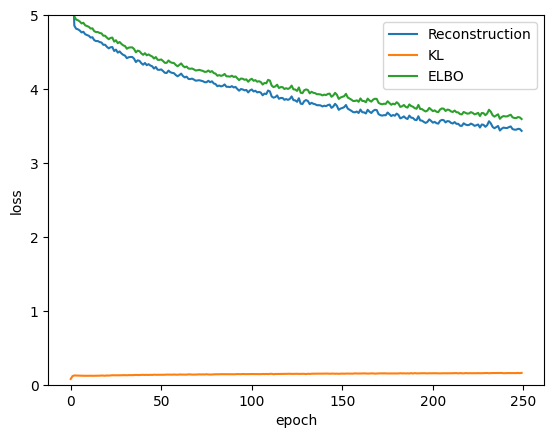

In [25]:
plt.plot(reproduction_losses, label="Reconstruction")
plt.plot(klds, label="KL")
plt.plot(losses, label="ELBO")
plt.legend()
plt.ylim(0, 5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

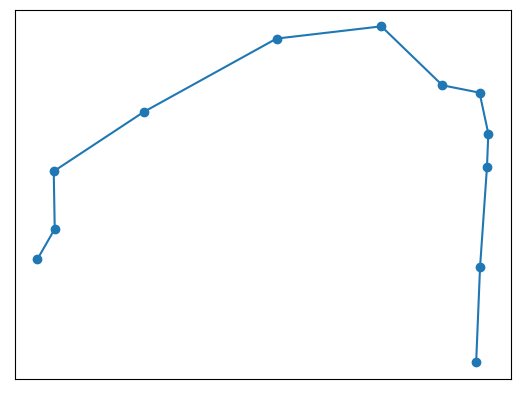

In [29]:
zs = torch.randn(latent_dim).to(DEVICE)
sampled_data = model.Decoder(zs)
sampled_data = sampled_data.cpu().detach().numpy().reshape(-1, 2)

plt.plot(sampled_data[:, 0], sampled_data[:, 1], "-o", alpha=1)
plt.xticks([])
plt.yticks([])
plt.show()

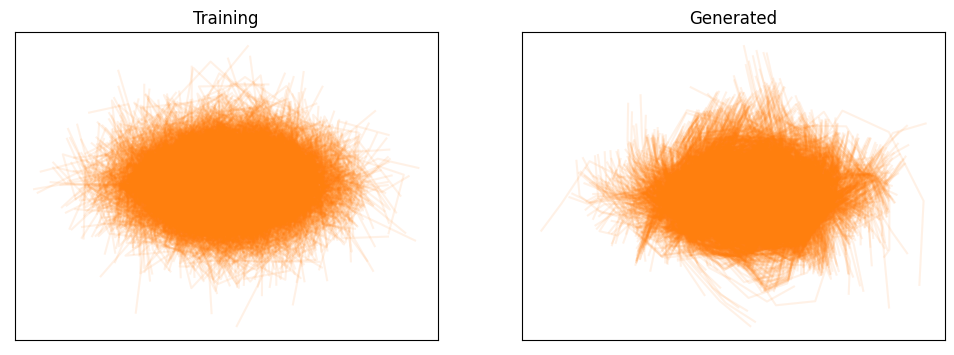

In [30]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

# sampled_data = batched_decoder(
#     np.random.normal(size=(data.shape[0], latent_dim)), theta
# ).reshape(data.shape[0], -1, 2)

zs = torch.randn(size=(data.shape[0], latent_dim)).to(DEVICE)
sampled_data = model.Decoder(zs)
sampled_data = sampled_data.cpu().detach().numpy().reshape(data.shape[0], -1, 2)

for i in range(0, data.shape[0]):
    axs[0].plot(data[i, :, 0], data[i, :, 1], "-", alpha=0.1, color="C1")
    axs[1].plot(
        sampled_data[i, :, 0], sampled_data[i, :, 1], "-", alpha=0.1, color="C1"
    )
axs[0].set_title("Training")
axs[1].set_title("Generated")
for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

/tmp/ipykernel_191605/141638851.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.linalg.norm(data[:, 0] - data[:, j], axis=1), ax=axs[i])
/tmp/ipykernel_191605/141638851.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/tmp/ipykernel_191605/141638851.py:4: UserWarning: 

`dist

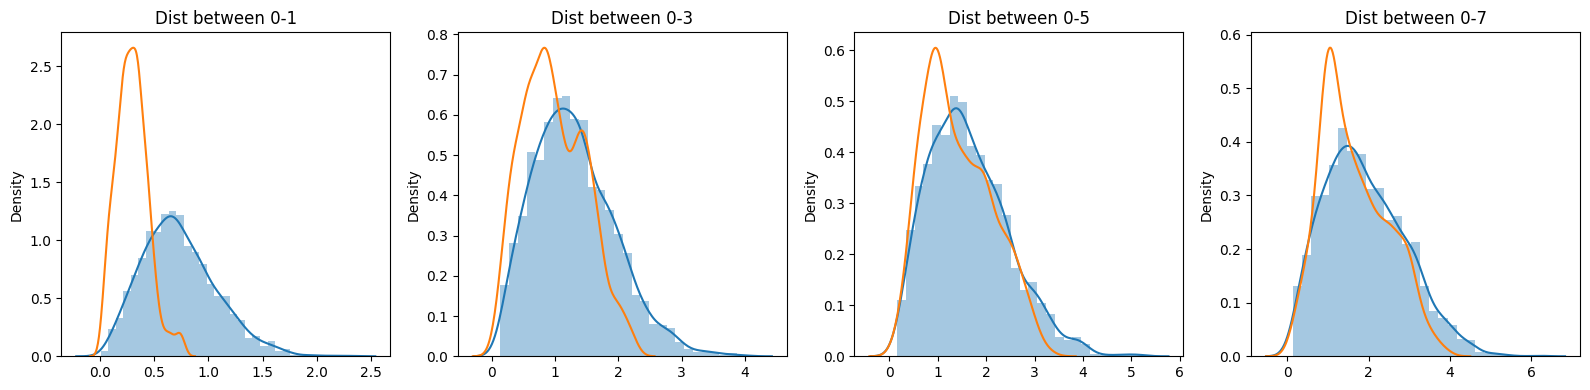

In [31]:
fig, axs = plt.subplots(ncols=4, squeeze=True, figsize=(16, 4))
for i, j in enumerate(range(1, 9, 2)):
    axs[i].set_title(f"Dist between 0-{j}")
    sns.distplot(np.linalg.norm(data[:, 0] - data[:, j], axis=1), ax=axs[i])
    sns.distplot(
        np.linalg.norm(sampled_data[:, 0] - sampled_data[:, j], axis=1),
        ax=axs[i],
        hist=False,
    )
plt.tight_layout()